Taylor Manivanh
8/23/2022
AB Testing

# What is A/B testing?

A/B testing is one of the most popular controlled experiments used to optimize web marketing strategies. It allows decision makers to choose the best design for a website by looking at the analytics results obtained with two possible alternatives A and B.

**A/B Testing Methodology**
- Visitors of a website are randomly served with one of the two designs (A and B)
- Data about their activity is collected by web analytics
- Given this data, one can apply statistical tests to determine whether one of the two designs has better efficacy

**Website Efficacy**
Discrete metrics (aka binomial metrics) have only the two possible values of 0 and 1
- Click through rate: if a user is shown an advertisement, do they click on it?
- Conversion rate: If a user is shown an advert, do they convert into customers?
- Bounce rate: if a user visits a website, is the following visited page on the same website?

Continuous metrics (aka nonbinomial metrics) may take continuous values that are not limited to a set two discrete states
- Average revenue per user: how much revenue does a user generate in a month?
- Average session duration: how long does a user stay on a website in a session?
- Average order value: what is the total value of the order of a user?

**Statistical Significance**
- It is fundamental to determine how likely it is that the observed discrepancy between the two samples originates from chance.

In [1]:
# Import Statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import binom
from scipy.stats import chi2_contingency, mannwhitneyu, norm, t, ttest_ind

%matplotlib inline

## 1. Two Sample Hypothesis Test
A two tailed test is a significance test in which alternative hypothesis has two ends. It determines that there is a relationship between variables in either direction. 

- Null Hypothesis: There is no significant difference between the efficacy of A and B
- Alternate Hypothesis: There is a significant difference between the efficacy of A and B
- p-value: is computed as the area under the two tails fo the probability density dunction (p(x)) of a chosen test statistic on all x's to p(x') <= p(our observation)
    - The computation of such p-value clearly depends on the data distribution

### 1a. Discrete Metrics

Looking at click-though rate. We randomly show visitors one of two possible designs of an advertisement, and based on how many of them click on it we need to determine whether our data significantly contradict the hypothesis that the two designs are equivalently efficient.

In [2]:
np.random.seed(42)

x = np.random.binomial(n=1, p=0.6, size=15)
y = np.random.binomial(n=1, p=0.4, size=19)

_, (a, c) = np.unique(x, return_counts=True)
_, (b, d) = np.unique(y, return_counts=True)

df = pd.DataFrame(data=[[a, b], [c, d]], 
                 index=["click", "no click"], 
                 columns=["A", "B"])
m = df.values

print("- Observations:")
print(f"  - Version A: = {x}")
print(f"  - Version B: = {y}")
print("")
print("- Contingency table:")
display(df)

- Observations:
  - Version A: = [1 0 0 1 1 1 1 0 0 0 1 0 0 1 1]
  - Version B: = [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1]

- Contingency table:


,A,B
click,7,15
no click,8,4


- nX = 15 visitors saw the advertisement A, and 7 of them clicked on it.
- nY = 19 visitors saw the advertisement B, and 15 of them clicked on it.

Looks like B was more effective, but how statistically siginificant is this discrepancy?

### 1b. Fisher's Exact Test
**Fisher's Exact Test**: statistical significance test used in the analysis of contingency tables. It is used to examine the significance of the association (contingency) between the two kinds of classification. 
Since we have a 2x2 contingency table we can use Fisher's exact test to compute an exact p-value and test our hypothesis.


**Hypergeometric Distribution**: is a discrete probability distribution that describes the probability of *k* successes (random draws for which the object drawn has a specified feature) in *n* draws, without replacement, from a finite population of size *N* that contains exactly *K* objects with that feature, wherein each draw is either a success or a failure.

In [3]:
def hypergeom(k, K, n, N):
    """Probability mass funciton of the hypergeometric distribution."""
    return binom(K, k) * binom(N-K, n-k) / binom(N, n)


def fisher_prob(m):
    """Probability of a given observed contingency table according to Fisher's exact test."""
    ((a, b), (c ,d)) = m
    k = a
    K = a+b
    n = a+c
    N = a+b+c+d
    return hypergeom(k, K, n, N)

def fisher_probs_histogram(m):
    """Computes prob mass function histogram accroding to Fisher's exact test."""
    neg_val = -min(m[0,0], m[1,1])
    pos_val = min(m[1,0], m[1,0])
    probs = []
    for k in range(neg_val, pos_val+1):
        m1 = m + np.array([[1, -1], [-1, 1]]) * k
        probs.append(fisher_prob(m1))
    return probs

- Fisher's exact test: p-val = 7.5%


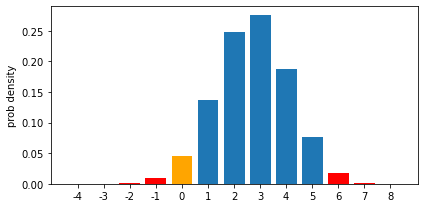

In [4]:
bars_h = np.array(fisher_probs_histogram(m))

f, ax = plt.subplots(figsize=(6, 3))
ii = np.arange(len(bars_h))
ax.bar(ii, bars_h)
idxs = bars_h <= fisher_prob(m)
ax.bar(ii[idxs], bars_h[idxs], color='r')
ax.set_ylabel("prob density")
p_val = bars_h[idxs].sum()
neg_val = -min(m[0,0], m[1,1])
pos_val = min(m[1,0], m[1,0])
ax.bar(ii[-neg_val], bars_h[-neg_val], color='orange')

ax.set_xticks(ii)
ax.set_xticklabels(np.arange(neg_val, pos_val+1))
f.tight_layout()
print(f"- Fisher's exact test: p-val = {100*p_val:.1f}%")

- the probability of seeing our actual observations is ~4.5%
- the probability of seeing even more unlikely observations in favor if B is ~1.0% (left tail);
- the probability of seeing observations even more unlikely observations in favor if A is ~2.0% (right tail).
- The Fisher's exact test gives p-value = ~7.5%